In [261]:
import cv2
import numpy as np
import pandas as pd
import pickle as cPickle
import time
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,confusion_matrix,multilabel_confusion_matrix,recall_score
from sklearn.preprocessing import normalize
from sklearn import svm
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [262]:
train_images_filenames = cPickle.load(open('resources/train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('resources/test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('resources/train_labels.dat','rb'))
test_labels = cPickle.load(open('resources/test_labels.dat','rb'))

In [263]:
import warnings
warnings.filterwarnings('ignore')

In [264]:
SIFTdetector = cv2.SIFT_create(nfeatures=300)

In [265]:
def compute_dense_sift(gray,sift,step):
    step_size = step
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]
    dense_feat = sift.compute(gray, kp)
    dense_feat_des = dense_feat[1]
    return dense_feat_des

In [266]:
step=5

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

k=128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in range(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

# knn = KNeighborsClassifier(n_neighbors=37,n_jobs=-1,metric='manhattan')
# knn.fit(visual_words, train_labels)

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} finished doing step={step}")


17:05:52 started doing step=5
17:06:59 finished doing step=5


<BarContainer object of 128 artists>

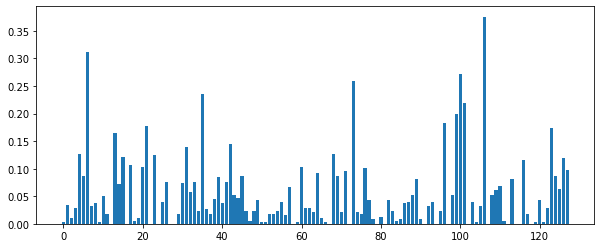

In [267]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(0,len(visual_words[0])),visual_words[1])

## Norm and scaler data

In [268]:
lin_data = []
rbf_data = []
hist_data = []

def intersection_kernel_cmp(X, Y):
    kernel = np.zeros((X.shape[0], Y.shape[0]))

    for d in range(X.shape[1]):
        column_1 = X[:, d].reshape(-1, 1)
        column_2 = Y[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

## Histogram intersection Kernel without scaler without normalization

In [269]:
hist_clf = svm.SVC(kernel=intersection_kernel_cmp)
hist_clf.fit(visual_words, train_labels)
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

scores = cross_val_score(hist_clf, visual_words_test, test_labels, cv=5)
hist_accuracy_noNorm_noScaler=scores.mean()*100
hist_data.append(hist_accuracy_noNorm_noScaler)


print("Histogram kernel without scaler without normalization accuracy: {}".format(hist_accuracy_noNorm_noScaler))


Histogram kernel without scaler without normalization accuracy: 80.79441760601182


## Histogram intersection Kernel without scaler with normalization (L1, L2, Max)

In [270]:
hist_clf = svm.SVC(kernel=intersection_kernel_cmp)
hist_clf.fit(visual_words, train_labels)

visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

scores_L1 = cross_val_score(hist_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(hist_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(hist_clf, visual_words_test_Max, test_labels, cv=5)

hist_accuracy_L1norm_noScaler=scores_L1.mean()*100
hist_accuracy_L2norm_noScaler=scores_L2.mean()*100
hist_accuracy_Maxnorm_noScaler=scores_Max.mean()*100

hist_data.append(hist_accuracy_L1norm_noScaler)
hist_data.append(hist_accuracy_L2norm_noScaler)
hist_data.append(hist_accuracy_Maxnorm_noScaler)

end = time.process_time()
time_elapsed = end-start

print("Histogram intersection kernel without scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(hist_accuracy_L1norm_noScaler, hist_accuracy_L2norm_noScaler, hist_accuracy_Maxnorm_noScaler))

Histogram intersection kernel without scaler with normalization 
	L1-norm accuracy: 80.1763668430335 
	L2-norm accuracy: 80.7936507936508 
	Max-norm accuracy: 80.04830917874398


## Histogram intersection Kernel with scaler without normalization (L1, L2, Max)

In [271]:
scaler = StandardScaler()
scaler.fit_transform(visual_words)

hist_clf = svm.SVC(kernel=intersection_kernel_cmp)
hist_clf.fit(visual_words, train_labels)

visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

visual_words_test_L1=scaler.transform(visual_words_test_L1)
visual_words_test_L2=scaler.transform(visual_words_test_L2)
visual_words_test_Max=scaler.transform(visual_words_test_Max)


scores_L1 = cross_val_score(hist_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(hist_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(hist_clf, visual_words_test_Max, test_labels, cv=5)


hist_accuracy_L1norm_scaler=scores_L1.mean()*100
hist_accuracy_L2norm_scaler=scores.mean()*100
hist_accuracy_Maxnorm_scaler=scores.mean()*100
hist_data.append(hist_accuracy_L1norm_scaler)
hist_data.append(hist_accuracy_L2norm_scaler)
hist_data.append(hist_accuracy_Maxnorm_scaler)



end = time.process_time()
time_elapsed = end-start


print("Histogram intersection kernel with scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(hist_accuracy_L1norm_scaler, hist_accuracy_L2norm_scaler, hist_accuracy_Maxnorm_scaler))

Histogram intersection kernel with scaler with normalization 
	L1-norm accuracy: 80.4217467985584 
	L2-norm accuracy: 80.79441760601182 
	Max-norm accuracy: 80.79441760601182


## Histogram intersection Kernel with scaler without normalization

In [272]:
start = time.process_time()

scaler = StandardScaler()
scaler.fit_transform(visual_words)


hist_clf = svm.SVC(kernel=intersection_kernel_cmp)
hist_clf.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

visual_words_test=scaler.transform(visual_words_test)
scores = cross_val_score(hist_clf, visual_words_test, test_labels, cv=5)
hist_accuracy_noNorm_scaler=scores.mean()*100
hist_data.append(hist_accuracy_noNorm_scaler)


end = time.process_time()
time_elapsed = end-start

print("Histogram intersection kernel with scaler without normalization accuracy: {}".format(hist_accuracy_noNorm_scaler))

Histogram intersection kernel with scaler without normalization accuracy: 80.4217467985584


## Linear Kernel without scaler without normalization

In [273]:
start = time.process_time()

lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
lin_accuracy_noNorm_noScaler=scores.mean()*100
lin_data.append(lin_accuracy_noNorm_noScaler)

end = time.process_time()
time_elapsed = end-start

print("Linear kernel without scaler without normalization accuracy: {}".format(lin_accuracy_noNorm_noScaler))

Linear kernel without scaler without normalization accuracy: 66.91358024691358


## Linear Kernel without scaler with normalization (L1, L2, Max)

In [274]:
start = time.process_time()

lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)

lin_accuracy_L1norm_noScaler=scores_L1.mean()*100
lin_accuracy_L2norm_noScaler=scores_L2.mean()*100
lin_accuracy_Maxnorm_noScaler=scores_Max.mean()*100

lin_data.append(lin_accuracy_L1norm_noScaler)
lin_data.append(lin_accuracy_L2norm_noScaler)
lin_data.append(lin_accuracy_Maxnorm_noScaler)

end = time.process_time()
time_elapsed = end-start

print("Linear kernel without scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(lin_accuracy_L1norm_noScaler, lin_accuracy_L2norm_noScaler, lin_accuracy_Maxnorm_noScaler))

Linear kernel without scaler with normalization 
	L1-norm accuracy: 76.82846407484088 
	L2-norm accuracy: 73.8539989264627 
	Max-norm accuracy: 71.25297139789893


## Linear kernel with scaler with normalization (L1, L2, Max)

In [275]:
start = time.process_time()

scaler = StandardScaler()
scaler.fit_transform(visual_words)

lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)

for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

visual_words_test_L1=scaler.transform(visual_words_test_L1)
visual_words_test_L2=scaler.transform(visual_words_test_L2)
visual_words_test_Max=scaler.transform(visual_words_test_Max)


scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)


lin_accuracy_L1norm_scaler=scores_L1.mean()*100
lin_accuracy_L2norm_scaler=scores.mean()*100
lin_accuracy_Maxnorm_scaler=scores.mean()*100
lin_data.append(lin_accuracy_L1norm_scaler)
lin_data.append(lin_accuracy_L2norm_scaler)
lin_data.append(lin_accuracy_Maxnorm_scaler)



end = time.process_time()
time_elapsed = end-start


print("Linear kernel with scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(lin_accuracy_L1norm_scaler, lin_accuracy_L2norm_scaler, lin_accuracy_Maxnorm_scaler))

Linear kernel with scaler with normalization 
	L1-norm accuracy: 71.62180814354728 
	L2-norm accuracy: 66.91358024691358 
	Max-norm accuracy: 66.91358024691358


## Linear kernel with scaler without normalization


In [276]:
start = time.process_time()

scaler = StandardScaler()
scaler.fit_transform(visual_words)

lin_clf = svm.LinearSVC(max_iter=2000, C=10)
lin_clf.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

visual_words_test=scaler.transform(visual_words_test)
scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
lin_accuracy_noNorm_scaler=scores.mean()*100
lin_data.append(lin_accuracy_noNorm_scaler)


end = time.process_time()
time_elapsed = end-start

print("Linear kernel with scaler without normalization accuracy: {}".format(lin_accuracy_noNorm_scaler))

Linear kernel with scaler without normalization accuracy: 67.40894103212945


## RBF Kernel without scaler without normalization

In [277]:
start = time.process_time()

rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)

rbf_accuracy_noNorm_noScaler=scores.mean()*100
rbf_data.append(rbf_accuracy_noNorm_noScaler)

end = time.process_time()
time_elapsed = end-start

print("RBF kernel without scaler with normalization accuracy: {}".format(rbf_accuracy_noNorm_noScaler))

RBF kernel without scaler with normalization accuracy: 14.621578099838967


## RBF Kernel without scaler with normalization (L1, L2, max)

In [278]:
start = time.process_time()

rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)


visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)


for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)


rbf_accuracy_L1norm_noScaler=scores_L1.mean()*100
rbf_accuracy_L2norm_noScaler=scores.mean()*100
rbf_accuracy_Maxnorm_noScaler=scores.mean()*100
rbf_data.append(rbf_accuracy_L1norm_noScaler)
rbf_data.append(rbf_accuracy_L2norm_noScaler)
rbf_data.append(rbf_accuracy_Maxnorm_noScaler)


end = time.process_time()
time_elapsed = end-start

print("RBF kernel without scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(rbf_accuracy_L1norm_noScaler, rbf_accuracy_L2norm_noScaler, rbf_accuracy_Maxnorm_noScaler))


RBF kernel without scaler with normalization 
	L1-norm accuracy: 76.82846407484088 
	L2-norm accuracy: 14.621578099838967 
	Max-norm accuracy: 14.621578099838967


## RBF Kernel with scaler with normalization (L1, L2, Max)

In [279]:
start = time.process_time()

scaler = StandardScaler()
scaler.fit_transform(visual_words)

rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)


visual_words_test_L1=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_L2=np.zeros((len(test_images_filenames),k),dtype=np.float32)
visual_words_test_Max=np.zeros((len(test_images_filenames),k),dtype=np.float32)


for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test_L1[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l1')
    visual_words_test_L2[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='l2')
    visual_words_test_Max[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1), norm='max')

visual_words_test_L1=scaler.transform(visual_words_test_L1)
visual_words_test_L2=scaler.transform(visual_words_test_L2)
visual_words_test_Max=scaler.transform(visual_words_test_Max)

scores_L1 = cross_val_score(lin_clf, visual_words_test_L1, test_labels, cv=5)
scores_L2 = cross_val_score(lin_clf, visual_words_test_L2, test_labels, cv=5)
scores_Max = cross_val_score(lin_clf, visual_words_test_Max, test_labels, cv=5)


rbf_accuracy_L1norm_scaler=scores_L1.mean()*100
rbf_accuracy_L2norm_scaler=scores.mean()*100
rbf_accuracy_Maxnorm_scaler=scores.mean()*100
rbf_data.append(rbf_accuracy_L1norm_scaler)
rbf_data.append(rbf_accuracy_L2norm_scaler)
rbf_data.append(rbf_accuracy_Maxnorm_scaler)


end = time.process_time()
time_elapsed = end-start

print("RBF kernel with scaler with normalization \n\tL1-norm accuracy: {} \n\tL2-norm accuracy: {} \n\tMax-norm accuracy: {}".format(rbf_accuracy_L1norm_scaler, rbf_accuracy_L2norm_scaler, rbf_accuracy_Maxnorm_scaler))


RBF kernel with scaler with normalization 
	L1-norm accuracy: 71.24990414845487 
	L2-norm accuracy: 14.621578099838967 
	Max-norm accuracy: 14.621578099838967


## RBF Kernel with scaler without normalization

In [280]:
start = time.process_time()

scaler = StandardScaler()
scaler.fit_transform(visual_words)

rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
rbf_svc.fit(visual_words, train_labels)

visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    des=compute_dense_sift(gray,SIFTdetector, step)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k).reshape(1,-1)

visual_words_test=scaler.transform(visual_words_test)

scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)

rbf_accuracy_noNorm_scaler=scores.mean()*100
rbf_data.append(rbf_accuracy_noNorm_scaler)


end = time.process_time()
time_elapsed = end-start

print("RBF kernel without scaler with normalization accuracy: {}".format(rbf_accuracy_noNorm_scaler))

RBF kernel without scaler with normalization accuracy: 14.621578099838967


## Data dump + graph generation

In [281]:

all_data = [lin_data,rbf_data, hist_data]
with open('scale_norm_data.pkl','wb') as f:
    cPickle.dump(all_data,f)

In [361]:
lin_data[0]
length*2

32

[66.91358024691358, 76.82846407484088, 73.8539989264627, 71.25297139789893, 71.62180814354728, 66.91358024691358, 66.91358024691358, 67.40894103212945]
[14.621578099838967, 76.82846407484088, 14.621578099838967, 14.621578099838967, 71.24990414845487, 14.621578099838967, 14.621578099838967, 14.621578099838967]
[80.79441760601182, 80.1763668430335, 80.7936507936508, 80.04830917874398, 80.4217467985584, 80.79441760601182, 80.79441760601182, 80.4217467985584]


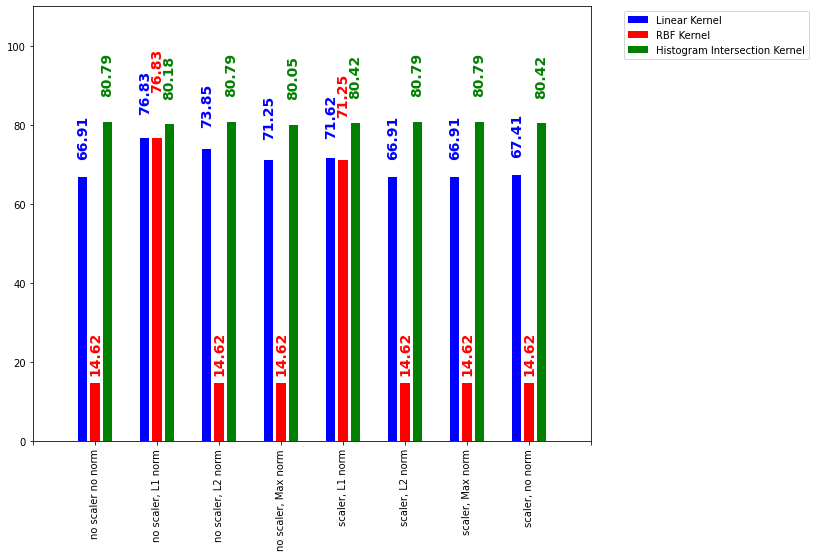

In [418]:
outputPickle = "scale_norm_data.pkl"
file = open(outputPickle, 'rb')
data = cPickle.load(file)
file.close()
for thing in data:
    print(thing)

lin_graph_data = []
rbf_graph_data = []
hist_graph_data = []

lin_graph_data = data[0]
rbf_graph_data = data[1]
hist_graph_data = data[2]

length = len(lin_graph_data)
x = np.arange(length)

categories_labels = ["", "no scaler no norm", "no scaler, L1 norm", "no scaler, L2 norm", "no scaler, Max norm", "scaler, L1 norm", "scaler, L2 norm", "scaler, Max norm", "scaler, no norm"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

plt.axis([-1, 8, 0, 110])
width = 0.2
barwidth = 0.15

plt.xticks(rotation=90, ha="center")
ax.set_xticklabels(categories_labels)


# plt.scatter(categories_labels, lin_graph_data)

ax.bar(x-width, lin_graph_data, barwidth, color='b', label='Linear Kernel')
ax.bar(x, rbf_graph_data, barwidth, color='r', label='RBF Kernel')
ax.bar(x + width, hist_graph_data, barwidth, color='g', label='Histogram Intersection Kernel')


# ax.scatter(categories_labels, lin_graph_data, s=150, c='b', marker="D", alpha=1, label='Linear Kernel')
# ax.scatter(categories_labels, rbf_graph_data, s=150, c='r', marker="s", alpha=0.5,  label='RBF Kernel')
# ax.scatter(categories_labels, hist_graph_data, s=150, c='g', marker="P", alpha=0.75,  label='Histogram Intersection Kernel')



plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

idx = 0

for i, txt in enumerate(lin_graph_data):
    lin_txt = "{:.2f}".format(txt)
    rbf_txt = "{:.2f}".format(rbf_graph_data[i])
    hist_txt = "{:.2f}".format(hist_graph_data[i])
    ax.annotate(lin_txt, (i - width, 1.15*lin_graph_data[i]), ha='center', va='center', c='b',weight='bold', size=14, rotation=90)
    ax.annotate(rbf_txt, (i , 1.15*rbf_graph_data[i]), ha='center', va='bottom', c='r',weight='bold', size=14, rotation=90)
    ax.annotate(hist_txt, (i+ width, 1.15*hist_graph_data[i]), ha='center', va='center', c='g',weight='bold', size=14, rotation=90)

plt.show()

In [ ]:
n = 0
m = 1

a
print("k")
b

In [ ]:
def get_pyramid_image_cells(image,level):
    # CURRENTLY WORKING ONLY FOR LEVELS 0,1,2 (1,4, and 16 cells)
    M = (image.shape[0])//(level+1)
    N = (image.shape[1])//(level+1)
    tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]
#     print(image.shape)
#     print("level=", level)
#     print("returning " + str(len(tiles)) + " tiles")
    return tiles


'''
for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    break

tiles = get_pyramid_image_cells(gray,2)
'''

## Calculating a histogram per cell and concatenating them
Compute a histogram for each part of the image and put these histograms together in a weighted concatenation 
(since there will be less words overall in a smaller cell).
The weighted concatenation can be a simple normalization of every histogram so the area of the histogram adds up to 1.
A pyramid of l levels will yield in 2^(2l) histograms n_words = k*(1+2**(2*pyramid_levels)).
the final image histogram is a concatenated vector  of  the  bin  values  of  all  the  histograms in  the  pyramid.
concatenation method used in:
http://lear.imag.fr/pub/203-bosch-civr07.pdf
https://core.ac.uk/download/pdf/82695491.pdf

TODO: Initialisation of concatenated_histogram. 

In [ ]:
step=5

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

Train_descriptors = []
Train_label_per_descriptor = []
pyramid_levels = 2 # level zero has 1 tile, level 1 has 4 tiles => 5 histograms that will be concatenated
for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    # break the image into pieces
    image_cells = []
    for i in range(pyramid_levels+1):

        level_cells = get_pyramid_image_cells(gray,level=i)
        image_cells = image_cells + level_cells
        # compute descriptors for each tile
    Train_descriptors_cell = []
    for cell in image_cells:
        des=compute_dense_sift(cell,SIFTdetector, step)
        Train_descriptors_cell.append(des)
    
    Train_descriptors.append(Train_descriptors_cell)
    Train_label_per_descriptor.append(labels)
    break
    
today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

In [ ]:
len(Train_descriptors[0])

In [ ]:
len(Train_descriptors[0][0])

In [ ]:
len(Train_descriptors[0][0][0])

In [ ]:
Train_descriptors[0][0][0]

In [ ]:
# train all cells as separate images
D=np.vstack([des for descriptors_cells in Train_descriptors for des in descriptors_cells])

In [ ]:
D.shape

In [ ]:
k=128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

In [ ]:
print(k*(1+2**(2*pyramid_levels)))

In [ ]:
len(Train_descriptors[0][0])

In [ ]:
visual_words=np.zeros((len(Train_descriptors),k*(1+2**(2*pyramid_levels))),dtype=np.float32)
for idx,cells in enumerate(Train_descriptors):

    image_histograms = []
    for id2,image_cell in enumerate(cells):
        cell_words = codebook.predict(image_cell)
        image_histograms.append(normalize(np.bincount(cell_words,minlength=k).reshape(1,-1)))
        # concatenated histogram has k*(1+2**(2*pyramid_levels)) bins
        # normalize(np.bincount(words,minlength=k).reshape(1,-1))

    concatenated_histogram=image_histograms[0].copy()
    for cell_idx in range(1,len(image_histograms)):
        # concatenate histograms
        concatenated_histogram = np.concatenate((concatenated_histogram,image_histograms[cell_idx]))
    visual_words[idx,:]=concatenated_histogram.flatten()
    
    #visual_words[idx,:]=np.bincount(words,minlength=k*(2**(2*pyramid_levels))) # this will just be longer as levels 
                                                                                # increase 
                                                                                # see: k*(2**(2*pyramid_levels)) long

# knn = KNeighborsClassifier(n_neighbors=37,n_jobs=-1,metric='manhattan')
# knn.fit(visual_words, train_labels) 

In [ ]:
visual_words[0,:].shape

TRAINED Visual Words tryin further worked until now

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(visual_words)

In [ ]:
lin_clf = svm.LinearSVC(max_iter=2000,C=10)
lin_clf.fit(visual_words, train_labels)

In [ ]:
rbf_svc = svm.SVC(kernel='rbf',C=1000,gamma=0.001)
rbf_svc.fit(visual_words, train_labels)

In [ ]:
visual_words[1].shape

In [ ]:
inter_svc = svm.SVC(kernel=intersection_kernel_cmp)
inter_svc.fit(visual_words,train_labels)

In [ ]:
today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

Test_descriptors = []
Test_label_per_descriptor = []
pyramid_levels = 1 # level zero has 1 tile, level 1 has 4 tiles => 5 histograms that will be concatenated
for filename,labels in zip(test_images_filenames,test_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    # break the image into pieces
    image_cells = []
    for i in range(pyramid_levels+1):

        level_cells = get_pyramid_image_cells(gray,level=i)
        image_cells = image_cells + level_cells
        # compute descriptors for each tile
    Test_descriptors_cell = []
    for cell in image_cells:
        des=compute_dense_sift(cell,SIFTdetector, step)
        Test_descriptors_cell.append(des)
        
    Test_descriptors.append(Test_descriptors_cell)
    Test_label_per_descriptor.append(labels)

In [ ]:
visual_words_test=np.zeros((len(Test_descriptors),k*(1+2**(2*pyramid_levels))),dtype=np.float32)
for idx,cells in enumerate(Test_descriptors):

    image_histograms = []
    for id2,image_cell in enumerate(cells):
        cell_words = codebook.predict(image_cell)
        image_histograms.append(normalize(np.bincount(cell_words,minlength=k).reshape(1,-1)))
        # concatenated histogram has k*(1+2**(2*pyramid_levels)) bins
        # normalize(np.bincount(words,minlength=k).reshape(1,-1))

    concatenated_histogram=image_histograms[0].copy()
    for cell_idx in range(1,len(image_histograms)):
        # concatenate histograms
        concatenated_histogram = np.concatenate((concatenated_histogram,image_histograms[cell_idx]))
    visual_words_test[idx,:]=concatenated_histogram.flatten()

In [ ]:
visual_words_test=scaler.transform(visual_words_test)
scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
accuracy=scores.mean()*100

print(accuracy)

In [ ]:
# visual_words_test=scaler.transform(visual_words_test)
scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)
accuracy=scores.mean()*100

print(accuracy)

## creating kernel for intersection of histograms

In [ ]:
def intersection_kernel_cmp(X, Y):
    return cv2.compareHist(X, Y, method=cv2.HISTCMP_INTERSECT)

# clf = svm.SVC(kernel=my_kernel)

In [ ]:
intersection_kernel_cmp(visual_words[0],visual_words[1])

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## GridSearchCV cross validation finding best parameters for RBF and Linear

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision_macro', 'recall_macro','accuracy']

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

data_results=[]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring=score
    )
    clf.fit(visual_words, train_labels)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        c=params['C']
        ker=params['kernel']
        if ker=='rbf': 
            gamma=params['gamma']
        else: gamma=None
            
        data_results.append([mean,std,c,gamma,ker,score])
        
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred))
#     print()

today = datetime.now()
dt_string = today.strftime("%H:%M:%S")
print(f"{dt_string} started doing step={step}")

In [ ]:
df=pd.DataFrame(data_results, columns=['mean_val','std_val','c','gamma','ker','score'])

In [ ]:
from sklearn import metrics
# sorted(metrics.SCORERS.keys())

In [ ]:
with open('GridSearchCV_rbf_linear_params.pkl','wb') as f:
    cPickle.dump(df,f)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Accuracy vs C', xlim=(0,1200), ylim=(0,1))
df2=df[df.score=='accuracy']
df2_rbf=df2[(df2.ker=='rbf')]
df2_linear=df2[(df2.ker=='linear')]
print("max for rbf\n",df2_rbf[df2_rbf.mean_val==df2_rbf.mean_val.max()])
print("max for linear\n",df2_linear.loc[df2_linear.mean_val==df2_linear.mean_val.max()])
# print(df2[df2.recall==df2.recall.max()])

ax.plot(df2_linear.c, df2_linear.mean_val, 'ro', label='linear')
ax.plot(df2_rbf.c, df2_rbf.mean_val, 'go', label='rbf')
ax.legend()

max_val = max(df2.mean_val)
max_idx = df2.c[df2.mean_val.idxmax()]
# ax.annotate("Max {:.2f}".format(max_val), xy=(max_idx, max_val),
#            weight='bold', size=14)

# arrowprops is a mpl.patches.FancyArrowPatch
_ = ax.annotate("Max accuracy {:.2f}".format(max_val), xy=(max_idx, max_val),
                weight='bold', size=14, 
                xytext=(.5, .9),
                textcoords='axes fraction',
                family='comic sans ms',
                arrowprops={})

## My Analysis for different DENSE

In [ ]:
def calculate_vis(step):
    step=step

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing step={step}")

    Train_descriptors = []
    Train_label_per_descriptor = []

    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    #     kpt,des=SIFTdetector.detectAndCompute(gray,None)
        des=compute_dense_sift(gray,SIFTdetector, step)
        Train_descriptors.append(des)
        Train_label_per_descriptor.append(labels)

    D=np.vstack(Train_descriptors)

    k=128
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)

    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)):
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

    # knn = KNeighborsClassifier(n_neighbors=37,n_jobs=-1,metric='manhattan')
    # knn.fit(visual_words, train_labels)

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing step={step}")
    
    scaler = StandardScaler()
    scaler.fit_transform(visual_words)
    
    lin_clf = svm.LinearSVC(max_iter=2000, C=10)
    lin_clf.fit(visual_words, train_labels)
    
    rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
    rbf_svc.fit(visual_words, train_labels)

    visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    #     kpt,des=SIFTdetector.detectAndCompute(gray,None)
        des=compute_dense_sift(gray,SIFTdetector, step)
        words=codebook.predict(des)
        visual_words_test[i,:]=normalize(np.bincount(words,minlength=k).reshape(1,-1))

    visual_words_test=scaler.transform(visual_words_test)
    
    scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
    accuracy_linear=scores.mean()*100

    print("linear=",accuracy_linear)

    scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)
    accuracy_rbf=scores.mean()*100

    print("rbf=",accuracy_rbf)
    
    return accuracy_linear,accuracy_rbf


In [ ]:
data_results_step =[]
steps_to_do=[5,20,50,100,300,500]
for step in steps_to_do:
    accuracy_linear,accuracy_rbf=calculate_vis(step)
    data_results_step.append([step,accuracy_linear,accuracy_rbf,1,1])
    
df=pd.DataFrame(data_results_step, columns=['step','accuracy_linear','accuracy_rbf','normalized','scaler'])    

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(title='Accuracy vs steps', xlim=(0,1200), ylim=(0,100))
df2=df
y_rbf=df2.accuracy_rbf
y_lin=df2.accuracy_linear
print("max for rbf\n",df2[df2.accuracy_rbf==df2.accuracy_rbf.max()])
print("max for linear\n",df2[df2.accuracy_linear==df2.accuracy_linear.max()])
# print(df2[df2.recall==df2.recall.max()])

ax.plot(df2.step, y_lin, 'r', label='linear')
ax.plot(df2.step, y_rbf, 'g', label='rbf')
plt.xlabel('step in dense')
plt.ylabel('accuracy')
ax.legend()

In [ ]:
df

In [ ]:
with open('Different_densities_analysis.pkl','wb') as f:
    cPickle.dump(df,f)

## My Analysis on Pyramid level

In [ ]:
def create_pyramid_levels(pyramid):
    step=5

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing step={pyramid}")

    Train_descriptors = []
    Train_label_per_descriptor = []
    pyramid_levels = pyramid # level zero has 1 tile, level 1 has 4 tiles => 5 histograms that will be concatenated

    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        # break the image into pieces
        image_cells = []
        for i in range(pyramid_levels+1):

            level_cells = get_pyramid_image_cells(gray,level=i)
            image_cells = image_cells + level_cells
            # compute descriptors for each tile
        Train_descriptors_cell = []
        for cell in image_cells:
            des=compute_dense_sift(cell,SIFTdetector, step)
            Train_descriptors_cell.append(des)

        Train_descriptors.append(Train_descriptors_cell)
        Train_label_per_descriptor.append(labels)

    D=np.vstack([des for descriptors_cells in Train_descriptors for des in descriptors_cells])

    #codebook

    k=128
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)

    #creating visual words for Training

    visual_words=np.zeros((len(Train_descriptors),k*21),dtype=np.float32)
    for idx,cells in enumerate(Train_descriptors):

        image_histograms = []
        for id2,image_cell in enumerate(cells):
            cell_words = codebook.predict(image_cell)
            image_histograms.append(normalize(np.bincount(cell_words,minlength=k).reshape(1,-1)))
            # concatenated histogram has k*(1+2**(2*pyramid_levels)) bins
            # normalize(np.bincount(words,minlength=k).reshape(1,-1))

        concatenated_histogram=image_histograms[0].copy()
        for cell_idx in range(1,len(image_histograms)):
            # concatenate histograms
            concatenated_histogram = np.concatenate((concatenated_histogram,image_histograms[cell_idx]))
        visual_words[idx,:]=concatenated_histogram.flatten()
        
    #PCA
    pca = PCA(n_components=127)
    VWpca = pca.fit_transform(visual_words)

    #SVN kernels

    scaler = StandardScaler()
    scaler.fit_transform(VWpca)

    lin_clf = svm.LinearSVC(max_iter=2000, C=10)
    lin_clf.fit(VWpca, train_labels)

    rbf_svc = svm.SVC(kernel='rbf', C=1000, gamma=0.001)
    rbf_svc.fit(VWpca, train_labels)

    today = datetime.now()
    dt_string = today.strftime("%H:%M:%S")
    print(f"{dt_string} started doing test step={pyramid}")

    #creating SIFT descriptor

    Test_descriptors = []
    Test_label_per_descriptor = []
    # pyramid_levels = 1 # level zero has 1 tile, level 1 has 4 tiles => 5 histograms that will be concatenated
    for filename,labels in zip(test_images_filenames,test_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        # break the image into pieces
        image_cells = []
        for i in range(pyramid_levels+1):

            level_cells = get_pyramid_image_cells(gray,level=i)
            image_cells = image_cells + level_cells
            # compute descriptors for each tile
        Test_descriptors_cell = []
        for cell in image_cells:
            des=compute_dense_sift(cell,SIFTdetector, step)
            Test_descriptors_cell.append(des)

        Test_descriptors.append(Test_descriptors_cell)
        Test_label_per_descriptor.append(labels)

    #creating visual tests

    visual_words_test=np.zeros((len(Test_descriptors),k*21),dtype=np.float32)
    for idx,cells in enumerate(Test_descriptors):

        image_histograms = []
        for id2,image_cell in enumerate(cells):
            cell_words = codebook.predict(image_cell)
            image_histograms.append(normalize(np.bincount(cell_words,minlength=k).reshape(1,-1)))
            # concatenated histogram has k*(1+2**(2*pyramid_levels)) bins
            # normalize(np.bincount(words,minlength=k).reshape(1,-1))

        concatenated_histogram=image_histograms[0].copy()
        for cell_idx in range(1,len(image_histograms)):
            # concatenate histograms
            concatenated_histogram = np.concatenate((concatenated_histogram,image_histograms[cell_idx]))
        visual_words_test[idx,:]=concatenated_histogram.flatten()


    #scaler test
    visual_words_test=scaler.transform(visual_words_test)
    
    #PCA
    vwtestpca = pca.transform(visual_words_test)

    #accuracy for test linear
#     scores = cross_val_score(lin_clf, visual_words_test, test_labels, cv=5)
    scores = cross_val_score(lin_clf, vwtestpca, test_labels, cv=5)
    accuracy_linear=scores.mean()*100

    print("linear=",accuracy_linear)


    #accuracy for test rbf
    scores = cross_val_score(rbf_svc, visual_words_test, test_labels, cv=5)
    accuracy_rbf=scores.mean()*100

    print("rbf=",accuracy_rbf)

    return accuracy_linear,accuracy_rbf

In [ ]:
piramid=[2]
data_pyramid_levels=[]
for level in piramid:
    accuracy_linear,accuracy_rbf=create_pyramid_levels(level)
    data_pyramid_levels.append([level,5,accuracy_linear,accuracy_rbf,1,1])

df_level=pd.DataFrame(data_pyramid_levels, columns=['level','step','accuracy_linear','accuracy_rbf','normalized','scaler'])    

In [ ]:
df_level

In [ ]:
with open('Different_pyramid_level_2.pkl','wb') as f:
    cPickle.dump(df_level,f)